# Emulators: First example

This example illustrates Bayesian inference on a time series, using [Adaptive Covariance MCMC](http://pints.readthedocs.io/en/latest/mcmc_samplers/adaptive_covariance_mcmc.html) with emulator neural networks .

It follows on from [Sampling: First example](../sampling/first-example.ipynb)

Like in the sampling example, I start by importing pints:

In [1]:
import pints

C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passi

In [2]:
def histogram(
        samples,
        kde=False,
        n_percentiles=None,
        parameter_names=None,
        ref_parameters=None,
        sample_names=None):
    """
    Takes one or more markov chains or lists of samples as input and creates
    and returns a plot showing histograms for each chain or list of samples.
    Returns a ``matplotlib`` figure object and axes handle.
    Parameters
    ----------
    samples
        A list of lists of samples, with shape
        ``(n_lists, n_samples, n_parameters)``, where ``n_lists`` is the
        number of lists of samples, ``n_samples`` is the number of samples in
        one list and ``n_parameters`` is the number of parameters.
    kde
        Set to ``True`` to include kernel-density estimation for the
        histograms.
    n_percentiles
        Shows only the middle n-th percentiles of the distribution.
        Default shows all samples in ``samples``.
    parameter_names
        A list of parameter names, which will be displayed on the x-axis of the
        histogram subplots. If no names are provided, the parameters are
        enumerated.
    ref_parameters
        A set of parameters for reference in the plot. For example, if true
        values of parameters are known, they can be passed in for plotting.
    """
    import matplotlib
    import matplotlib.pyplot as plt

    # Check matplotlib version
    use_old_matplotlib = False

    # If we switch to Python3 exclusively, bins and alpha can be keyword-only
    # arguments
    bins = 40
    alpha = 0.5
    n_list = len(samples)
    _, n_param = samples[0].shape

    # Check parameter names
    if parameter_names is None:
        parameter_names = ['Parameter' + str(i + 1) for i in range(n_param)]
    elif len(parameter_names) != n_param:
        raise ValueError(
            'Length of `parameter_names` must be same as number of'
            ' parameters.')

    # Check number of parameters
    for samples_j in samples:
        if n_param != samples_j.shape[1]:
            raise ValueError(
                'All samples must have the same number of parameters.'
            )

    # Check reference parameters
    if ref_parameters is not None:
        if len(ref_parameters) != n_param:
            raise ValueError(
                'Length of `ref_parameters` must be same as number of'
                ' parameters.')

    # Set up figure
    fig, axes = plt.subplots(
        n_param, 1, figsize=(6, 2 * n_param),
        squeeze=False,    # Tell matlab to always return a 2d axes object
    )

    # Plot first samples
    for i in range(n_param):
        for j_list, samples_j in enumerate(samples):
            # Add histogram subplot
            axes[i, 0].set_xlabel(parameter_names[i])
            axes[i, 0].set_ylabel('Frequency')
            if n_percentiles is None:
                xmin = np.min(samples_j[:, i])
                xmax = np.max(samples_j[:, i])
            else:
                xmin = np.percentile(samples_j[:, i],
                                     50 - n_percentiles / 2.)
                xmax = np.percentile(samples_j[:, i],
                                     50 + n_percentiles / 2.)
            xbins = np.linspace(xmin, xmax, bins)
            if sample_names is not None:
                label=sample_names[j_list]
            else:
                label='Samples ' + str(1 + j_list)
            if use_old_matplotlib:  # pragma: no cover
                axes[i, 0].hist(
                    samples_j[:, i], bins=xbins, alpha=alpha, normed=True,
                    label=label)
            else:
                axes[i, 0].hist(
                    samples_j[:, i], bins=xbins, alpha=alpha, density=True,
                    label=label)

            # Add kde plot
            if kde:
                x = np.linspace(xmin, xmax, 100)
                axes[i, 0].plot(x, stats.gaussian_kde(samples_j[:, i])(x))

        # Add reference parameters if given
        if ref_parameters is not None:
            # For histogram subplot
            ymin_tv, ymax_tv = axes[i, 0].get_ylim()
            axes[i, 0].plot(
                [ref_parameters[i], ref_parameters[i]],
                [0.0, ymax_tv],
                '--', c='k')
    if n_list > 1:
        axes[0, 0].legend()

    plt.tight_layout()
    return fig, axes[:, 0]

In [3]:
def surface(
        x_grid, y_grid, z_grid,
        cmap="Blues", angle=(25, 300), alpha=1.,
        fontsize=14, labelpad=10,
        title="", x_label="", y_label="", z_label="log_likelihood"):
    """
    Creates 3d contour plot given a grid for each axis.
    Arguments:
    ``x_grid``
        An NxN grid of values.
    ``y_grid``
        An NxN grid of values.
    ``z_grid``
        An NxN grid of values. z_grid determines colour.
    ``cmap``
        (Optional) Colour map used in the plot
    ``angle``
        (Optional) tuple specifying the viewing angle of the graph
    ``alpha``
        (Optional) alpha parameter of the surface
    ``fill``
        (Optional) Used to specify whether or not contour plot should be filled
        Default False.
    ``fontsize``
        (Optional) the fontsize used for labels
    ``labelpad``
        (Optional) distance of axis labels from the labels
    ``x_label``
        (Optional) The label of the x-axis
    ``y_label``
        (Optional) The label of the y-axis
    ``z_label``
        (Optional) The label of the z-axis
    Returns a ``matplotlib`` figure object and axes handle.
    """
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D 
    ax = plt.axes(projection='3d')
    # Data for a three-dimensional line
    ax.plot_surface(x_grid, y_grid, z_grid, cmap=cmap, alpha=alpha)
    ax.view_init(*angle)

    fontsize = fontsize
    labelpad = labelpad

    if title:
        plt.title(title, fontsize=fontsize)
    if x_label:
        ax.set_xlabel(x_label, fontsize=fontsize, labelpad=labelpad)
    if y_label:
        ax.set_ylabel(y_label, fontsize=fontsize, labelpad=labelpad)
    if z_label:
        ax.set_zlabel(z_label, fontsize=fontsize, labelpad=labelpad)

    return ax

Next, I create a model class using the "Logistic" toy model included in pints:

In [4]:
import pints.toy as toy
model = toy.LogisticModel()

In order to generate some test data, I choose an arbitrary set of "true" parameters:

In [5]:
true_parameters = [0.015, 500]

And a number of time points at which to sample the time series:

In [6]:
import numpy as np
times = np.linspace(0, 1000, 400)

Using these parameters and time points, I generate an example dataset:

In [7]:
org_values = model.simulate(true_parameters, times)

And make it more realistic by adding gaussian noise:

In [8]:
noise = 5
values = org_values + np.random.normal(0, noise, org_values.shape)

Using matplotlib, I look at the noisy time series I just simulated:

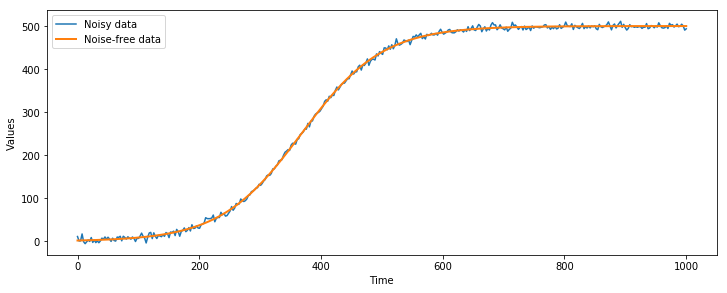

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4.5))
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, values, label='Noisy data')
plt.plot(times, org_values, lw=2, label='Noise-free data')
plt.legend()
plt.show()

Now, I have enough data (a model, a list of times, and a list of values) to formulate a PINTS problem:

In [10]:
problem = pints.SingleOutputProblem(model, times, values)

I now have some toy data, and a model that can be used for forward simulations. To make it into a probabilistic problem, a _noise model_ needs to be added. This can be done using the `GaussianLogLikelihood` function, which assumes independently distributed Gaussian noise over the data, and can calculate log-likelihoods:

In [11]:
#log_likelihood = pints.GaussianLogLikelihood(problem)
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, noise)

The resulting noise has mean zero and an unknown standard deviation. The standard deviation can be inferred along with the other parameters, meaning the number of parameters of the problem increased by one!

In [12]:
print('Original number of parameters: ' + str(problem.n_parameters()))

Original number of parameters: 2


In [13]:
print('New number of parameters: ' + str(log_likelihood.n_parameters()))

New number of parameters: 2


This means the vector of true parameters has to be updated:

In [14]:
#true_parameters += [noise]
print(true_parameters)

[0.015, 500]


This `log_likelihood` represents the _conditional probability_ $p(y|\theta)$, given a set of parameters $\theta$ and a series of $y=$ `values`, it can calculate the probability of finding those values if the real parameters are $\theta$.

This can be used in a Bayesian inference scheme to find the quantity of interest:

$p(\theta|y) = \frac{p(\theta)p(y|\theta)}{p(y)} \propto p(\theta)p(y|\theta)$

To solve this, a _prior_ is defined, indicating an initial guess about what the parameters should be. 
Similarly as using a _log-likelihood_ (the natural logarithm of a likelihood), this is defined by using a _log-prior_. Hence, the above equation simplifies to:

$\log p(\theta|y) \propto \log p(\theta) + \log p(y|\theta)$

In this example, it is assumed that we don't know too much about the prior except lower and upper bounds for each variable: We assume the first model parameter is somewhere on the interval $[0.01, 0.02]$, the second model parameter on $[400, 600]$, and the standard deviation of the noise is somewhere on $[1, 100]$.

In [15]:
# Create bounds for our parameters and get prior
bounds = pints.RectangularBoundaries([0.01, 400], [0.02, 600])
log_prior = pints.UniformLogPrior(bounds)

With this prior, the numerator of Bayes' rule can be defined -- the unnormalised log posterior, $\log \left[ p(y|\theta) p(\theta) \right]$, which is the natural logarithm of the likelihood times the prior:

In [16]:
# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

Finally we create a list of guesses to use as initial positions. We'll run three MCMC chains so we create three initial positions:

In [17]:
xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]

And this gives us everything we need to run an MCMC routine:

In [18]:
chains = pints.mcmc_sample(log_posterior, 3, xs)

Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0         0         0          0:00.0
2     9      0         0         0          0:00.0
3     12     0.25      0         0          0:00.0
20    63     0.143     0.0476    0.0952     0:00.0
40    123    0.0732    0.0244    0.0732     0:00.0
60    183    0.0492    0.0164    0.0492     0:00.0
80    243    0.0494    0.0123    0.037      0:00.1
100   303    0.0396    0.0099    0.0297     0:00.1
120   363    0.0331    0.00826   0.0248     0:00.1
140   423    0.0284    0.00709   0.0213     0:00.1
160   483    0.0248    0.0124    0.0248     0:00.1
180   543    0.0276    0.011     0.0221     0:00.1
Initial phase completed.
200   603    0.0249    0.00995   0.0199     0:00.1
220   663    0.0317    0.0271    0.0226     0:00.1
240   723    0.0498    0.0415    0.0498     0:00.2
260   783   

3280  9843   0.251     0.244     0.25       0:02.4
3300  9903   0.251     0.244     0.251      0:02.4
3320  9963   0.251     0.244     0.25       0:02.4
3340  10023  0.251721  0.244     0.249      0:02.4
3360  10083  0.252     0.244     0.249033   0:02.4
3380  10143  0.252     0.243     0.25       0:02.5
3400  10203  0.252     0.242     0.25       0:02.5
3420  10263  0.251     0.242     0.249      0:02.5
3440  10323  0.251     0.242     0.248      0:02.5
3460  10383  0.252     0.242     0.248      0:02.5
3480  10443  0.252     0.24131   0.248      0:02.5
3500  10503  0.251928  0.241     0.247      0:02.5
3520  10563  0.250497  0.241     0.247      0:02.6
3540  10623  0.25      0.241     0.246      0:02.6
3560  10683  0.25      0.24      0.246      0:02.6
3580  10743  0.251     0.241     0.245      0:02.6
3600  10803  0.25      0.24      0.244932   0:02.6
3620  10863  0.251     0.24      0.244      0:02.6
3640  10923  0.25      0.23922   0.244      0:02.6
3660  10983  0.252     0.238   

6600  19803  0.24      0.238     0.244      0:04.8
6620  19863  0.240296  0.238     0.244      0:04.8
6640  19923  0.24      0.238     0.244      0:04.9
6660  19983  0.24      0.238     0.244      0:04.9
6680  20043  0.24      0.238     0.244      0:04.9
6700  20103  0.24      0.238     0.244      0:04.9
6720  20163  0.239     0.237911  0.244      0:04.9
6740  20223  0.238837  0.237     0.243      0:04.9
6760  20283  0.239     0.237     0.243      0:04.9
6780  20343  0.239     0.237     0.243      0:05.0
6800  20403  0.238     0.237     0.243      0:05.0
6820  20463  0.239     0.237     0.243      0:05.0
6840  20523  0.239     0.237     0.243      0:05.0
6860  20583  0.238     0.237     0.243      0:05.0
6880  20643  0.239     0.236     0.242552   0:05.0
6900  20703  0.238806  0.236     0.243      0:05.0
6920  20763  0.239     0.237     0.243      0:05.1
6940  20823  0.238     0.237     0.242      0:05.1
6960  20883  0.238     0.237     0.242      0:05.1
6980  20943  0.238     0.237   

9860  29583  0.239     0.236     0.24       0:07.2
9880  29643  0.238     0.236     0.24       0:07.2
9900  29703  0.238     0.236     0.24       0:07.2
9920  29763  0.239     0.236     0.239996   0:07.3
9940  29823  0.239     0.236     0.24       0:07.3
9960  29883  0.239     0.236     0.239735   0:07.3
9980  29943  0.238954  0.236     0.239455   0:07.3
10000 30000  0.2388    0.2358    0.2397     0:07.3
Halting: Maximum number of iterations (10000) reached.


## Using Pints' diagnostic plots to inspect the results

We can take a further look at the obtained results using Pints's [diagnostic plots](http://pints.readthedocs.io/en/latest/diagnostic_plots.html).

First, we use the [trace](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.trace) method to see if the three chains converged to the same solution.

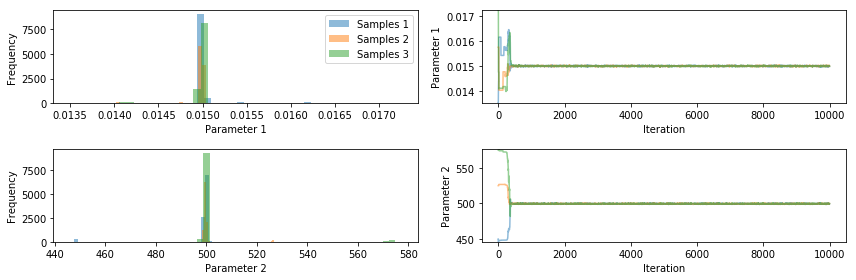

In [19]:
import pints.plot
pints.plot.trace(chains)
plt.show()

Based on this plot, it looks like the three chains become very similar after about 1000 iterations.
To be safe, we throw away the first 2000 samples and continue our analysis with the first chain.

In [20]:
chain = chains[0]
chain = chain[2000:]

We can also look for autocorrelation in the chains, using the [autocorrelation()](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.autocorrelation) method. If everything went well, the samples in the chain should be relatively independent, so the autocorrelation should get quite low when the `lag` on the x-axis increases.

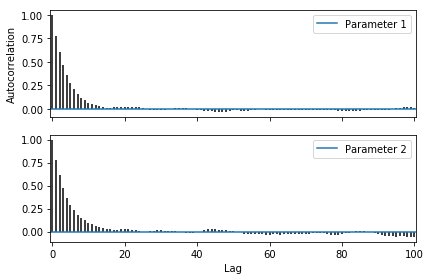

In [21]:
pints.plot.autocorrelation(chain)
plt.show()

Now we can inspect the inferred distribution by plotting histograms:

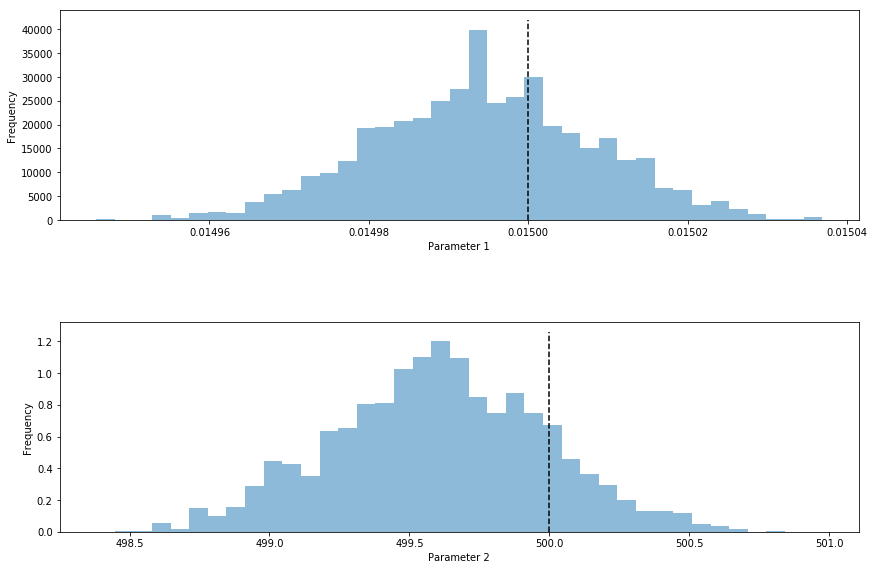

In [22]:
fig, axes = pints.plot.histogram([chain], ref_parameters=true_parameters)

# Show where the sample standard deviation of the generated noise is:
noise_sample_std = np.std(values - org_values)
#axes[-1].axvline(noise_sample_std, color='orange', label='Sample standard deviation of noise')
#axes[-1].legend()

fig.set_size_inches(14, 9)
plt.show()

Here we've analysed each parameter in isolation, but we can also look at correlations between parameters we found using the [pairwise()](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.pairwise) plot.

To speed things up, we'll first apply some _thinning_ to the chain:

In [23]:
thinned_chain = chain[::10]

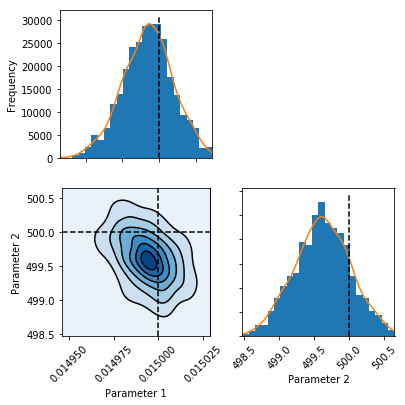

In [24]:
pints.plot.pairwise(thinned_chain, kde=True, ref_parameters=true_parameters)
plt.show()

As these plots show, we came pretty close to the original "true" values (represented by the blue line). 
But not exactly... Worse, the method seems to suggest a normal distribution but around the wrong point.
To find out what's going on, we can plot the log-posterior function near the true parameters:

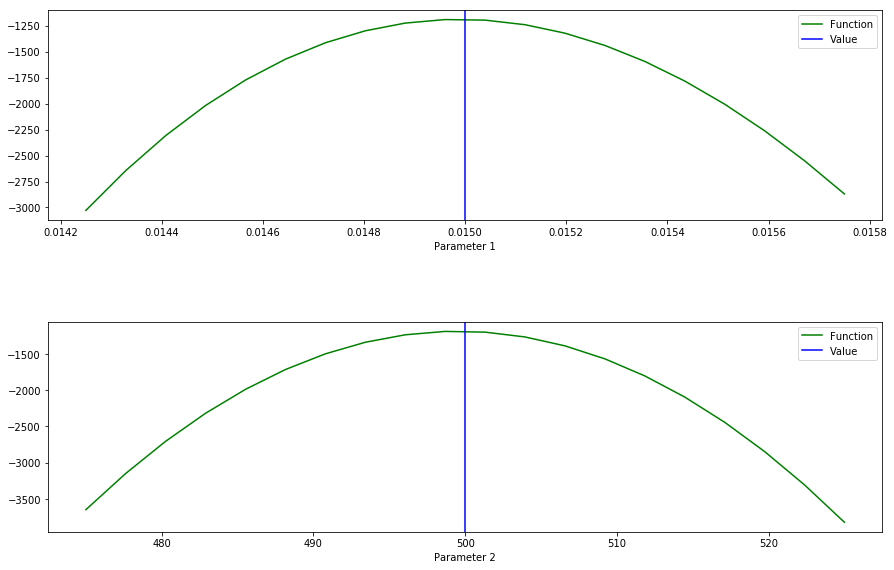

In [25]:
# Plot log-posterior function
fig, axes = pints.plot.function(log_posterior, true_parameters)

# Add a line showing the sample standard deviation of the generated noise
#axes[-1].axvline(noise_sample_std, color='orange', label='Sample standard deviation of noise')
#axes[-1].legend()

# Customise the figure size
fig.set_size_inches(14, 9)
plt.show()

As this plot (created entirely without MCMC!) shows, the MCMC method did well, but our estimate of the true parameters has become _biased_ by the stochastic noise! You can test this by increasing the number of sample points, which increases the size of the noise sample, and reduces the bias.

Finally, we can look at the bit that really matters: The model predictions made from models with the parameters we found (a _posterior predictive check_). Thes can be plotted using the [series()](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.series) method.

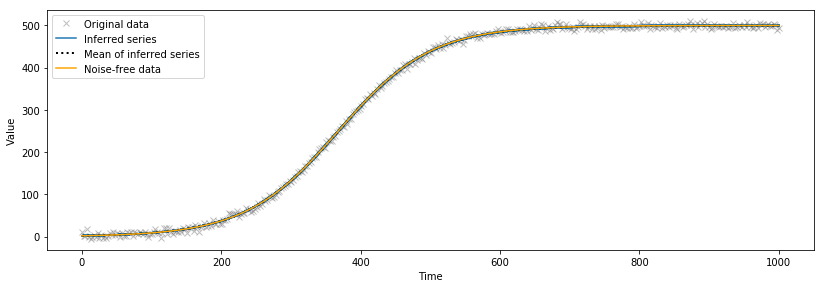

In [26]:
fig, axes = pints.plot.series(chain, problem)

# Customise the plot, and add the original, noise-free data
fig.set_size_inches(12,4.5)
plt.plot(times, org_values, c='orange', label='Noise-free data')
plt.legend()
plt.show()

-1195.4915980549272
[1.50034788e-02 4.98003500e+02]
-1187.1238837784394


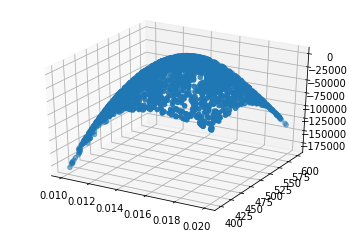

In [27]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

input_parameters = log_prior.sample(2000)
xs = [p[0] for p in input_parameters]
ys = [p[1] for p in input_parameters]
input_parameters[:5]

likelihoods = np.apply_along_axis(log_likelihood, 1, input_parameters)
likelihoods[:5]

print(max(likelihoods))
idx = list(likelihoods).index(max(likelihoods))
print(input_parameters[idx])
print(log_likelihood([0.015, 500]))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, list(likelihoods))
plt.show()

In [28]:
print(input_parameters[:5])

[[1.38719206e-02 4.55382225e+02]
 [1.17062650e-02 5.17431664e+02]
 [1.21828219e-02 5.36639898e+02]
 [1.94924350e-02 4.64218265e+02]
 [1.28543742e-02 5.81555451e+02]]


In [29]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(input_parameters, likelihoods, test_size=0.3, random_state=0)

emu = pints.MultiLayerNN(log_likelihood, X_train, y_train, 
                          input_scaler=MinMaxScaler(), output_scaler=StandardScaler())
#emu.set_parameters(layers=6, neurons=64, hidden_activation='relu', activation='tanh', learning_rate=0.00001)
emu.set_parameters(layers=6, neurons=64, hidden_activation='relu', activation='linear', learning_rate=0.0001)
hist = emu.fit(epochs=1000, batch_size=32, X_val=X_valid, y_val=y_valid, verbose=0)
#emu.summary()

In [30]:
emu([0.015, 500])

array([[-1184.385]], dtype=float32)

In [31]:
log_likelihood([0.015, 500])

-1187.1238837784394

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


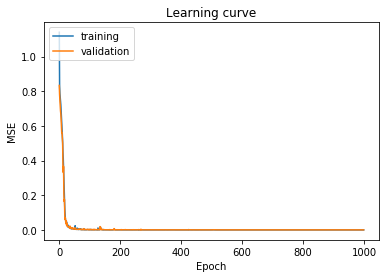

In [32]:
# summarize history for loss
print(hist.history.keys())
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Learning curve')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


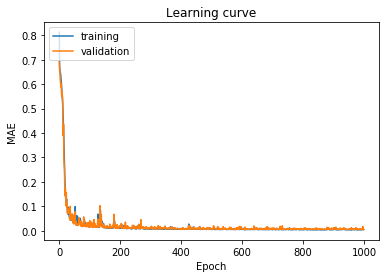

In [33]:
# summarize history for loss
print(hist.history.keys())
plt.plot(hist.history['mean_absolute_error'])
plt.plot(hist.history['val_mean_absolute_error'])
plt.title('Learning curve')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

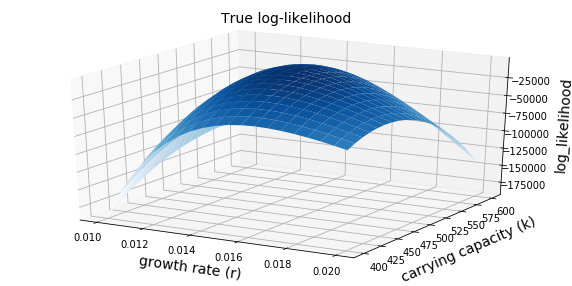

In [34]:
test_splits = 20 # number of splits along each axis
r_grid, k_grid, test_data = pints.generate_grid(bounds.lower(), 
                                                  bounds.upper(), 
                                                  test_splits)

model_prediction = pints.predict_grid(log_likelihood, test_data)

plt.figure(figsize = (10, 5))
surface(r_grid, k_grid, model_prediction, title = "True log-likelihood",
                     x_label = "growth rate (r)",
                     y_label = "carrying capacity (k)")

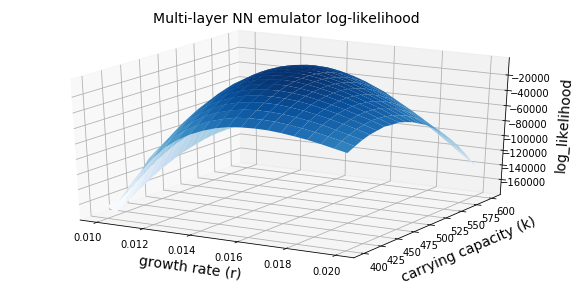

In [35]:
emu_prediction = pints.predict_grid(emu, test_data)

plt.figure(figsize = (10, 5))
ax = surface(r_grid, 
             k_grid, 
             emu_prediction, 
             title = "Multi-layer NN emulator log-likelihood",
             x_label = "growth rate (r)",
             y_label = "carrying capacity (k)")

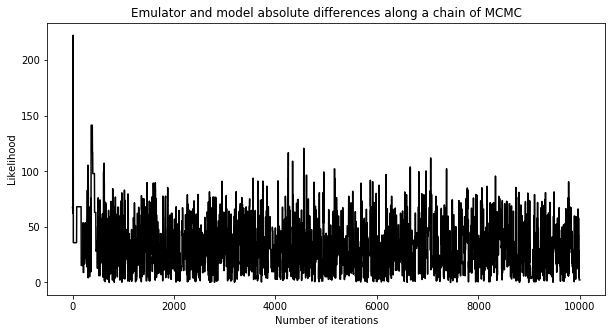

2.2701541334595277

In [36]:
chain = chains[0]
emu_prediction = np.apply_along_axis(emu, 1, chain).flatten()
model_prediction = np.apply_along_axis(log_likelihood, 1, chain).flatten()
diffs = np.abs(model_prediction - emu_prediction)

iters = np.linspace(0, 10000, len(chain))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute differences along a chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Likelihood")
plt.plot(iters, diffs, color = "Black")
plt.show()

diffs[-1]

In [37]:
print(emu_prediction)

[-24308.06   -24308.06   -24308.06   ...  -1184.4358  -1184.4358
  -1184.4358]


In [38]:
log_posterior_emu = pints.LogPosterior(emu, log_prior)
xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]

In [39]:
chains_emu = pints.mcmc_sample(log_posterior_emu, 3, xs)

Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0         0         0          0:00.0
2     9      0         0         0          0:00.0
3     12     0         0         0          0:00.0
20    63     0.143     0         0.0476     0:00.0
40    123    0.0732    0         0.0244     0:00.0
60    183    0.0656    0.0164    0.0164     0:00.1
80    243    0.0617    0.0123    0.0123     0:00.1
100   303    0.0495    0.0198    0.0297     0:00.1
120   363    0.0413    0.0165    0.0331     0:00.1
140   423    0.0355    0.0142    0.0426     0:00.2
160   483    0.0311    0.0124    0.0373     0:00.2
180   543    0.0276    0.011     0.0387     0:00.2
Initial phase completed.
200   603    0.0299    0.0149    0.039801   0:00.2
220   663    0.0317    0.0136    0.0452     0:00.3
240   723    0.0622    0.0166    0.0664     0:00.4
260   783   

3140  9423   0.255     0.282     0.26       0:08.7
3160  9483   0.255     0.282     0.26       0:08.8
3180  9543   0.256     0.281     0.262      0:08.8
3200  9603   0.255     0.281     0.261      0:08.9
3220  9663   0.255     0.281     0.26       0:08.9
3240  9723   0.255     0.281     0.259      0:09.0
3260  9783   0.255     0.28      0.259      0:09.1
3280  9843   0.256     0.279488  0.258153   0:09.1
3300  9903   0.255     0.278     0.258      0:09.2
3320  9963   0.254     0.278     0.257      0:09.2
3340  10023  0.255     0.277     0.256      0:09.3
3360  10083  0.255     0.277     0.256      0:09.3
3380  10143  0.255     0.277     0.255      0:09.4
3400  10203  0.254925  0.276     0.255      0:09.5
3420  10263  0.256     0.277112  0.254      0:09.5
3440  10323  0.256     0.278     0.255      0:09.6
3460  10383  0.256     0.277     0.255      0:09.6
3480  10443  0.256     0.278     0.254      0:09.7
3500  10503  0.256     0.278     0.253      0:09.7
3520  10563  0.256     0.277478

6360  19083  0.249     0.249     0.239585   0:17.9
6380  19143  0.249     0.248     0.239      0:18.0
6400  19203  0.248     0.24793   0.239      0:18.0
6420  19263  0.248     0.248     0.238      0:18.1
6440  19323  0.248     0.248     0.239      0:18.1
6460  19383  0.248     0.248     0.239      0:18.2
6480  19443  0.248     0.248     0.238852   0:18.2
6500  19503  0.247     0.247808  0.239      0:18.3
6520  19563  0.247048  0.248     0.239      0:18.4
6540  19623  0.247     0.248     0.239      0:18.4
6560  19683  0.247     0.247     0.239      0:18.5
6580  19743  0.246771  0.247     0.239      0:18.6
6600  19803  0.247     0.247     0.238      0:18.6
6620  19863  0.247     0.247     0.239      0:18.7
6640  19923  0.246     0.247     0.239      0:18.7
6660  19983  0.246     0.247     0.239      0:18.8
6680  20043  0.245     0.246     0.239      0:18.9
6700  20103  0.245635  0.246     0.239218   0:18.9
6720  20163  0.245     0.246     0.239      0:19.0
6740  20223  0.245     0.246   

9600  28803  0.242     0.246     0.239      0:27.1
9620  28863  0.242     0.246     0.238      0:27.2
9640  28923  0.242     0.246     0.239      0:27.2
9660  28983  0.242625  0.246     0.239      0:27.3
9680  29043  0.243     0.246049  0.238      0:27.3
9700  29103  0.243     0.246     0.238      0:27.4
9720  29163  0.242     0.246     0.238      0:27.5
9740  29223  0.242     0.246     0.238      0:27.5
9760  29283  0.242     0.246     0.238      0:27.6
9780  29343  0.243     0.246     0.238      0:27.6
9800  29403  0.243     0.246     0.238      0:27.7
9820  29463  0.242847  0.246     0.237      0:27.8
9840  29523  0.243     0.246     0.237      0:27.8
9860  29583  0.243     0.246     0.237      0:27.9
9880  29643  0.243     0.246     0.237      0:28.0
9900  29703  0.243     0.246     0.237      0:28.0
9920  29763  0.242     0.246     0.237      0:28.1
9940  29823  0.242     0.247     0.237      0:28.1
9960  29883  0.243     0.247     0.237      0:28.2
9980  29943  0.243     0.247   

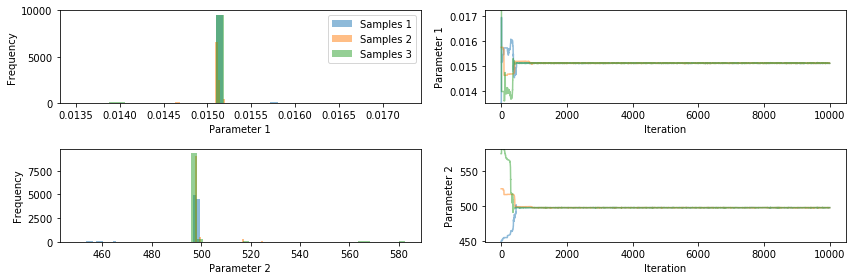

In [40]:
pints.plot.trace(chains_emu)
plt.show()

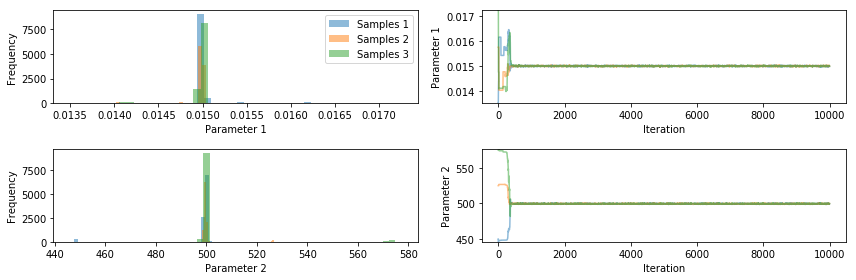

In [41]:
pints.plot.trace(chains)
plt.show()

In [42]:
chain_emu = chains_emu[0]
chain_emu = chain_emu[2000:]
chain = chains[0]
chain = chain[2000:]

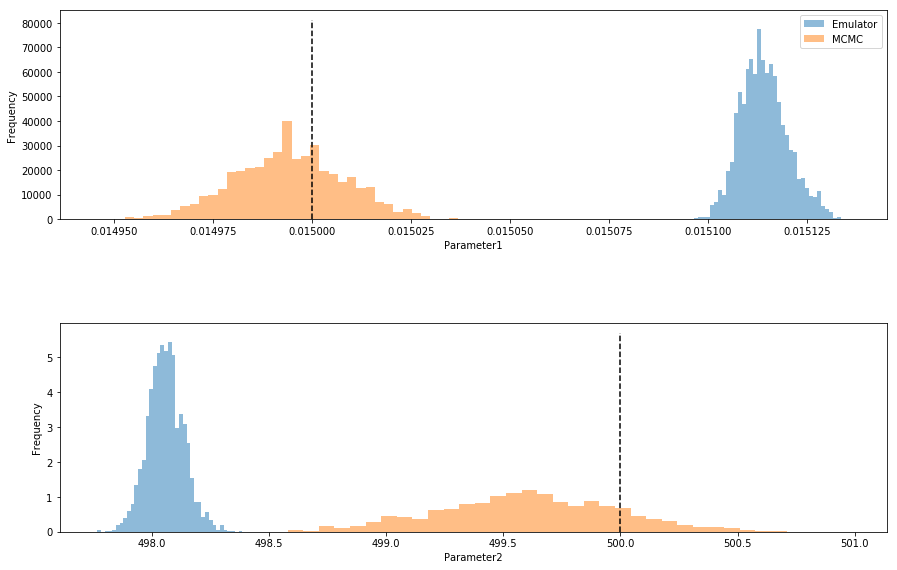

In [43]:
fig, axes = histogram([chain_emu, chain], ref_parameters=true_parameters, sample_names=["Emulator", "MCMC"])
fig.set_size_inches(14, 9)
plt.show()

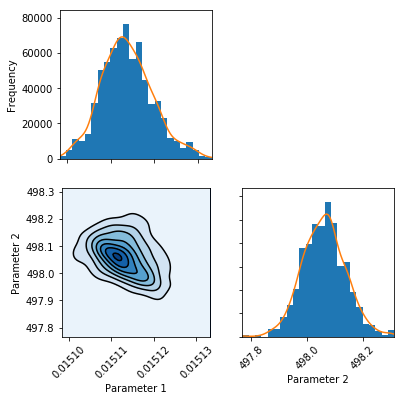

In [44]:
thinned_chain_emu = chain_emu[::10]
pints.plot.pairwise(thinned_chain_emu, kde=True, ref_parameters=true_parameters)
plt.show()

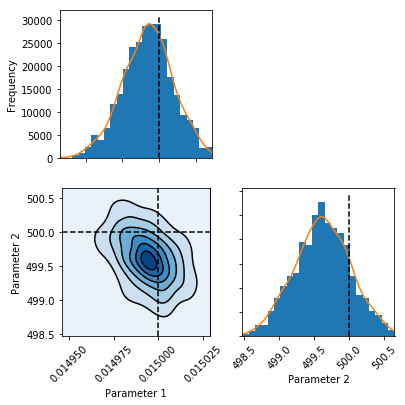

In [45]:
pints.plot.pairwise(thinned_chain, kde=True, ref_parameters=true_parameters)
plt.show()

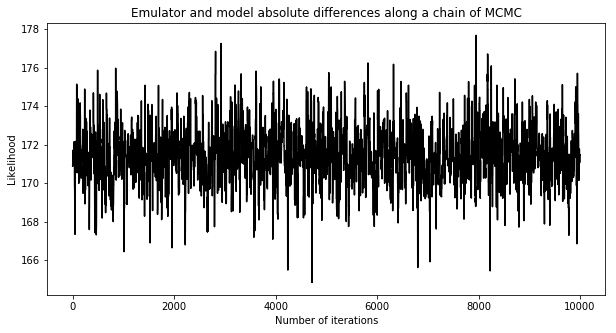

171.47724641861578

In [46]:
emu_prediction = np.apply_along_axis(emu, 1, chain_emu).flatten()
model_prediction = np.apply_along_axis(log_likelihood, 1, chain).flatten()
diffs = np.abs(model_prediction - emu_prediction)

iters = np.linspace(0, 10000, len(chain_emu))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute differences along a chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Likelihood")
plt.plot(iters, diffs, color = "Black")
plt.show()

diffs[-1]

In [47]:
chain_emu

array([[1.51147607e-02, 4.97971819e+02],
       [1.51167745e-02, 4.97965062e+02],
       [1.51167745e-02, 4.97965062e+02],
       ...,
       [1.51064613e-02, 4.98136548e+02],
       [1.51064613e-02, 4.98136548e+02],
       [1.51064613e-02, 4.98136548e+02]])

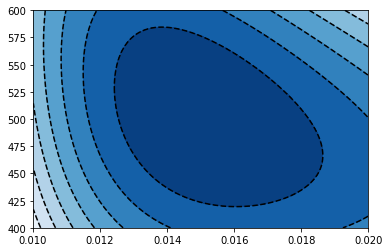

In [48]:
# Create grid
x = [p[0] for p in input_parameters]
y = [p[1] for p in input_parameters]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
plt.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
plt.contour(xx, yy, ll, colors='k')
plt.show()

AttributeError: 'AxesSubplot' object has no attribute 'autoscale_None'

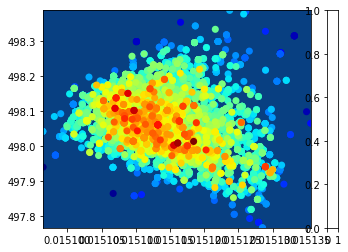

In [49]:
fig, ax = plt.subplots()                   

# Show density 
#ax.imshow(np.rot90(ll), cmap=plt.cm.Blues, extent=[xmin, xmax, ymin, ymax])

# Add contour lines
ax.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])                                                                     

# Plot chain_emu
x = [p[0] for p in chain_emu]
y = [p[1] for p in chain_emu]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
idx = diffs.argsort()
x_sorted = np.array(x)[idx]
y_sorted = np.array(y)[idx]
diffs_sorted = diffs[idx]

# Plot chain_emu
#ax.plot(x, y, 'k.', markersize=2)    
ax.set_xlim([xmin, xmax])                                                                           
ax.set_ylim([ymin, ymax])

ax.scatter(x_sorted, y_sorted, c=diffs_sorted, s=50, edgecolor='', cmap=plt.cm.jet)
fig.colorbar(ax)
plt.show()

Running...
Using Emulated Metropolis MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0         0         0          0:00.0
2     9      0.333     0         0.333      0:00.0
3     12     0.5       0         0.25       0:00.0
20    63     0.0952    0.0476    0.0952     0:00.0
40    123    0.0488    0.0488    0.0976     0:00.0
60    183    0.082     0.0492    0.082      0:00.0
80    243    0.0864    0.0617    0.0617     0:00.1
100   303    0.0693    0.0693    0.0495     0:00.1
120   363    0.0661    0.0661    0.0413     0:00.1
140   423    0.0709    0.0567    0.0355     0:00.1
160   483    0.0621    0.0559    0.0373     0:00.1
180   543    0.0552    0.0552    0.0331     0:00.1
200   603    0.0547    0.0547    0.0299     0:00.1
220   663    0.0498    0.0543    0.0271     0:00.2
240   723    0.0456    0.0539    0.029      0:00.2
260   783    0.0421    0.0498    0.0268   

3320  9963   0.0307    0.0166    0.0298     0:02.2
3340  10023  0.0308    0.0165    0.0296     0:02.2
3360  10083  0.0306    0.0164    0.0298     0:02.2
3380  10143  0.0305    0.0163    0.0299     0:02.2
3400  10203  0.0306    0.0162    0.0297     0:02.2
3420  10263  0.0304    0.0161    0.0298     0:02.2
3440  10323  0.0302    0.0163    0.0296     0:02.3
3460  10383  0.0303    0.0162    0.0295     0:02.3
3480  10443  0.0302    0.0161    0.0293     0:02.3
3500  10503  0.0303    0.016     0.0291     0:02.3
3520  10563  0.0304    0.0159    0.0293     0:02.3
3540  10623  0.0305    0.0161    0.0291     0:02.3
3560  10683  0.0303    0.0163    0.0292     0:02.3
3580  10743  0.0302    0.0162    0.029      0:02.3
3600  10803  0.03      0.0161    0.0294     0:02.4
3620  10863  0.0298    0.016     0.0295     0:02.4
3640  10923  0.0297    0.0162    0.0297     0:02.4
3660  10983  0.0295    0.0161    0.0295     0:02.4
3680  11043  0.0296    0.016     0.0293     0:02.4
3700  11103  0.0295    0.0162  

6760  20283  0.0203    0.0118    0.0246     0:04.4
6780  20343  0.0202    0.0118    0.0245     0:04.4
6800  20403  0.0201    0.0118    0.0244     0:04.4
6820  20463  0.0201    0.0117    0.0243     0:04.4
6840  20523  0.02      0.0117    0.0244     0:04.5
6860  20583  0.02      0.0117    0.0243     0:04.5
6880  20643  0.0199    0.0118    0.0243     0:04.5
6900  20703  0.0199    0.0117    0.0242     0:04.5
6920  20763  0.0198    0.0117    0.0241     0:04.5
6940  20823  0.0197    0.0117    0.0242     0:04.5
6960  20883  0.0197    0.0116    0.0241     0:04.5
6980  20943  0.0196    0.0116    0.0241     0:04.5
7000  21003  0.0196    0.0116    0.024      0:04.6
7020  21063  0.0195    0.0115    0.0239     0:04.6
7040  21123  0.0195    0.0115    0.0239     0:04.6
7060  21183  0.0197    0.0115    0.0238     0:04.6
7080  21243  0.01963   0.0114    0.0237     0:04.6
7100  21303  0.0196    0.0114    0.0237     0:04.6
7120  21363  0.0195    0.0114    0.0236     0:04.6
7140  21423  0.0195    0.0113  

10160 30483  0.0148    0.00935   0.0187     0:06.6
10180 30543  0.0147    0.00933   0.0187     0:06.6
10200 30603  0.0147    0.00931   0.0186     0:06.6
10220 30663  0.0147    0.00929   0.0186     0:06.6
10240 30723  0.0146    0.00928   0.0186     0:06.7
10260 30783  0.0146    0.00926   0.0185     0:06.7
10280 30843  0.0146    0.00934   0.0185     0:06.7
10300 30903  0.0146    0.00932   0.0184     0:06.7
10320 30963  0.0145    0.0093    0.0184     0:06.7
10340 31023  0.0145    0.00928   0.0184     0:06.7
10360 31083  0.0146    0.00927   0.0184     0:06.7
10380 31143  0.0145    0.00925   0.018399   0:06.7
10400 31203  0.0145    0.00923   0.0184     0:06.8
10420 31263  0.0145    0.00921   0.0183     0:06.8
10440 31323  0.0145    0.00919   0.0183     0:06.8
10460 31383  0.0144    0.00918   0.0183     0:06.8
10480 31443  0.0144    0.00916   0.0182     0:06.8
10500 31503  0.0144    0.00914   0.0182     0:06.8
10520 31563  0.0144    0.00912   0.0182     0:06.8
10540 31623  0.0143    0.00911 

13560 40683  0.0122    0.00789   0.0152     0:08.8
13580 40743  0.0122    0.00788   0.0152     0:08.8
13600 40803  0.0122    0.00787   0.0151     0:08.8
13620 40863  0.0122    0.00786   0.0151     0:08.9
13640 40923  0.0122    0.007844  0.0152     0:08.9
13660 40983  0.0122    0.00791   0.0152     0:08.9
13680 41043  0.0122    0.00789   0.0151     0:08.9
13700 41103  0.0122    0.00788   0.0151     0:08.9
13720 41163  0.0122    0.00787   0.0151     0:08.9
13740 41223  0.0122    0.00786   0.0151     0:08.9
13760 41283  0.0121    0.00785   0.015      0:08.9
13780 41343  0.0122    0.00784   0.015      0:09.0
13800 41403  0.0122    0.00783   0.015      0:09.0
13820 41463  0.0122    0.00781   0.015      0:09.0
13840 41523  0.0123    0.0078    0.015      0:09.0
13860 41583  0.0123    0.00779   0.0149     0:09.0
13880 41643  0.012319  0.00778   0.0149     0:09.0
13900 41703  0.0123    0.00777   0.0149     0:09.0
13920 41763  0.0123    0.00776   0.0149     0:09.1
13940 41823  0.0123    0.00775 

16900 50703  0.0113    0.00716   0.0131     0:11.0
16920 50763  0.0113    0.00715   0.0131     0:11.0
16940 50823  0.0113    0.00714   0.0131     0:11.0
16960 50883  0.0113    0.00713   0.0131     0:11.0
16980 50943  0.0113    0.00713   0.0131     0:11.1
17000 51003  0.0113    0.00712   0.0131     0:11.1
17020 51063  0.0113    0.00711   0.013      0:11.1
17040 51123  0.0113    0.0071    0.013      0:11.1
17060 51183  0.0113    0.00709   0.013      0:11.1
17080 51243  0.0112    0.00708   0.013      0:11.1
17100 51303  0.0112    0.00708   0.013      0:11.1
17120 51363  0.0112    0.00707   0.013      0:11.2
17140 51423  0.0112    0.00706   0.013      0:11.2
17160 51483  0.0112    0.00705   0.0129     0:11.2
17180 51543  0.0112    0.00704   0.0129     0:11.2
17200 51603  0.0112    0.00703   0.0129     0:11.2
17220 51663  0.0111    0.00703   0.0129     0:11.2
17240 51723  0.0111    0.00702   0.0129     0:11.2
17260 51783  0.0111    0.00701   0.0129     0:11.2
17280 51843  0.0111    0.007   

20180 60543  0.0103    0.00644   0.0113     0:13.2
20200 60603  0.0103    0.00644   0.0113     0:13.2
20220 60663  0.0103    0.00643   0.0113     0:13.2
20240 60723  0.0103    0.00642   0.0113     0:13.2
20260 60783  0.0103    0.00642   0.0113     0:13.2
20280 60843  0.0103    0.00641   0.0113     0:13.2
20300 60903  0.0102    0.0064    0.0113     0:13.2
20320 60963  0.0103    0.0064    0.0113     0:13.3
20340 61023  0.0103    0.00639   0.0113     0:13.3
20360 61083  0.0103    0.00638   0.0112     0:13.3
20380 61143  0.0104    0.00638   0.0112     0:13.3
20400 61203  0.0103    0.00637   0.0112     0:13.3
20420 61263  0.0103    0.00637   0.0112     0:13.3
20440 61323  0.0103    0.00636   0.0113     0:13.3
20460 61383  0.0103    0.00635   0.0112     0:13.4
20480 61443  0.0103    0.00635   0.0112     0:13.4
20500 61503  0.0103    0.00634   0.0112     0:13.4
20520 61563  0.0103    0.00633   0.0112     0:13.4
20540 61623  0.0103    0.00633   0.0112     0:13.4
20560 61683  0.0103    0.00632 

23520 70563  0.00978   0.00595   0.0104     0:15.4
23540 70623  0.00977   0.00595   0.0104     0:15.4
23560 70683  0.00976   0.00594   0.0104     0:15.4
23580 70743  0.00975   0.00594   0.0105     0:15.4
23600 70803  0.00975   0.00593   0.0105     0:15.4
23620 70863  0.00974   0.00593   0.0105     0:15.4
23640 70923  0.00973   0.00592   0.0105     0:15.4
23660 70983  0.00972   0.00592   0.0105     0:15.4
23680 71043  0.00971   0.00591   0.0105     0:15.5
23700 71103  0.0097    0.00591   0.0105     0:15.5
23720 71163  0.0097    0.0059    0.0105     0:15.5
23740 71223  0.00969   0.0059    0.0105     0:15.5
23760 71283  0.00968   0.00589   0.0105     0:15.5
23780 71343  0.00967   0.00589   0.0105     0:15.5
23800 71403  0.00966   0.00588   0.0105     0:15.5
23820 71463  0.00966   0.00588   0.0105     0:15.6
23840 71523  0.00965   0.00591   0.0104     0:15.6
23860 71583  0.00964   0.00591   0.0104     0:15.6
23880 71643  0.00967   0.00595   0.0104     0:15.6
23900 71703  0.00966   0.00594 

26860 80583  0.00886   0.00592   0.00961    0:17.6
26880 80643  0.00885   0.00591   0.0096     0:17.6
26900 80703  0.00885   0.00595   0.00959    0:17.6
26920 80763  0.00884   0.00594   0.00958    0:17.6
26940 80823  0.00887   0.00594   0.00958    0:17.6
26960 80883  0.00886   0.00593   0.00957    0:17.6
26980 80943  0.0089    0.00593   0.00956    0:17.6
27000 81003  0.00889   0.00593   0.00956    0:17.7
27020 81063  0.00888   0.00592   0.00955    0:17.7
27040 81123  0.00888   0.00592   0.00954    0:17.7
27060 81183  0.00887   0.00591   0.00953    0:17.7
27080 81243  0.00886   0.00591   0.00953    0:17.7
27100 81303  0.00886   0.0059    0.00952    0:17.7
27120 81363  0.00885   0.0059    0.00951    0:17.7
27140 81423  0.00884   0.0059    0.00951    0:17.8
27160 81483  0.00884   0.00589   0.0095     0:17.8
27180 81543  0.00883   0.00589   0.00949    0:17.8
27200 81603  0.00882   0.00592   0.00952    0:17.8
27220 81663  0.00882   0.00591   0.00959    0:17.8
27240 81723  0.00881   0.00591 

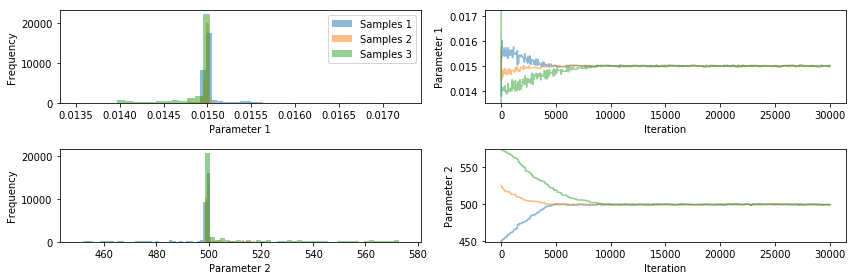

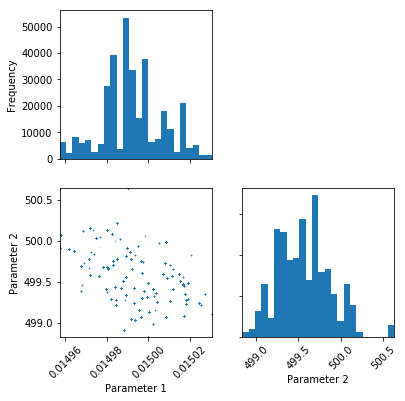

In [53]:
# Choose starting points for 3 mcmc chains
x0s = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05, #1.1
    np.array(true_parameters) * 1.15,
]
# Choose a covariance matrix for the proposal step
sigma0 = np.abs(true_parameters) * 5e-4

# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 3, x0s, sigma0=sigma0, method=pints.EmulatedMetropolisMCMC, f=emu)

# Add stopping criterion
mcmc.set_max_iterations(30000)

# Disable logging mode
#mcmc.set_log_to_screen(False)

# Run!
print('Running...')
emulated_chains = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(emulated_chains)

# Discard warm up
emulated_chains_thinned = emulated_chains[:, 10000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(emulated_chains_thinned))

# Look at distribution in chain 0
pints.plot.pairwise(emulated_chains_thinned[0])

# Show graphs
plt.show()

In [ ]:
# Choose starting points for 3 mcmc chains
x0s = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05, #1.1
    np.array(true_parameters) * 1.15,
]
# Choose a covariance matrix for the proposal step
sigma0 = np.abs(true_parameters) * 5e-4

# Create mcmc routine
mcmc = pints.MCMCController(emu, 3, x0s, sigma0=sigma0, method=pints.EmulatedMetropolisMCMC, f=log_posterior)

# Add stopping criterion
mcmc.set_max_iterations(30000)

# Disable logging mode
#mcmc.set_log_to_screen(False)

# Run!
print('Running...')
emulated_chains = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(emulated_chains)

# Discard warm up
emulated_chains_thinned = emulated_chains[:, 10000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(emulated_chains_thinned))

# Look at distribution in chain 0
pints.plot.pairwise(emulated_chains_thinned[0])

# Show graphs
plt.show()